# Zonal Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from matplotlib import cm, colors

import pylandstats as pls

# let us use a custom colormap
custom_cmap = colors.ListedColormap([
    (0, 0, 0, 0),
    (0.6, 0, 0, 1),
    (.95, .9, .75, 1),
], N=3)
cm.register_cmap(name='custom', cmap=custom_cmap)
plt.rcParams['image.cmap'] = 'custom'

Consider the following landscape of the Canton of Vaud, Switzerland:

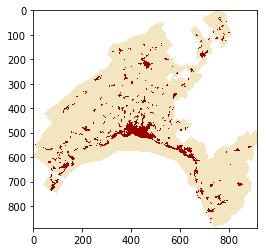

In [2]:
URBAN_CLASS_VAL = 1
input_filepath = '../data/clc/vaud_g100_clc00_V18_5.tif'

with rasterio.open(input_filepath) as src:
    plt.imshow(src.read(1))

Red and cream pixels represent urban and natural land uses respectively. At the center of our Landscape stands a large urban patch, which corresponds to the agglomeration of Lausanne.

Landscape metrics are very sensitive to the spatial extent of the map. Therefore, when evaluating the landscape patterns of the agglomeration of Lausanne, the computed values for the metrics would strongly depend on how such agglomeration extent is defined. In order to overcome such issue, landscape studies often study how metrics vary for a set of spatial extents.

The PyLandStats library features two classes that might be used to that end: `BufferAnalysis` and the more generic `ZonalAnalysis`.

## Buffer Analysis

In line with the classic concentric models of location and land use, we are often interested in evaluate how the landscape patterns change across the urban-rural gradient.
In fact, gradient analysis is a well-established approach within ecological studies which consists on evaluating the spatial variation of the environmental characteristics as one moves progressively from the highly-developed urban cores to the less intense suburbs until the rural and natural hinterlands.

To that end, PyLandStats features the `BufferAnalysis` class, which defines a series of spatial extents for our landscape based on buffers of increasing distances around our feature of interest - in this example, the agglomeration of Lausanne.

### From Point

We might define a given coordinate as the center of our region of interest (in this example, the center of Lausanne) and a series of buffer distances around that point:

In [3]:
from shapely.geometry import Point

# latitude and longitude of the center of Lausanne according to OpenStreetMap
base_mask = Point(6.6327025, 46.5218269)
base_mask_crs = '+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs'

# buffer distances (in meters)
buffer_dists = [10000, 15000, 20000]

then, we can use the `BufferAnalysis` class of Pylandstats as in (note that we need to provide the CRS of the geometry - in this example, the coordinate point):

In [4]:
ba = pls.BufferAnalysis(input_filepath,
                        base_mask,
                        buffer_dists,
                        base_mask_crs=base_mask_crs)

Then `BufferAnalysis` instance will automatically generate the three landscapes of interest (one for each buffer distance) by masking the pixels of the input raster

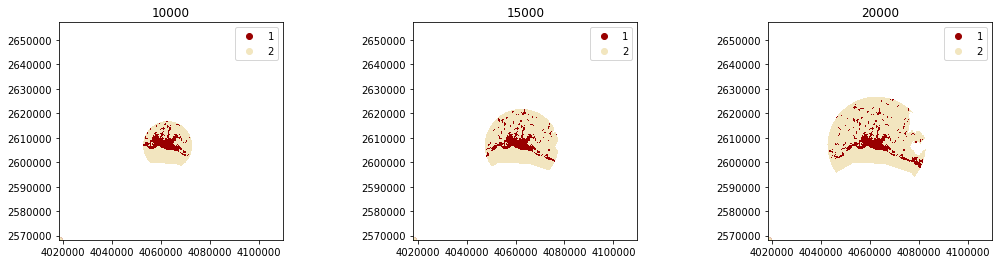

In [5]:
fig = ba.plot_landscapes()

And we can now compute and plot the landscape metrics for each of the buffered landscapes.

Like `SpatioTemporalAnalysis`, `BufferAnalysis` only supports class and landscape-level metrics, which again, can be computed by means of its methods `compute_class_metrics_df` and `compute_landscape_metrics_df` respectively, e.g.,

In [6]:
ba.compute_class_metrics_df()

metric                 total_area proportion_of_landscape number_of_patches  \
class_val buffer_dists                                                        
1         10000              7261                 24.9648                20   
          15000              9630                 16.7106                46   
          20000             12149                 13.3476                76   
2         10000             21824                 75.0352                 4   
          15000             47998                 83.2894                 4   
          20000             78871                 86.6524                 5   

metric                 patch_density largest_patch_index total_edge  \
class_val buffer_dists                                                
1         10000             0.068764             21.5472     223900   
          15000            0.0798223             11.5326     395200   
          20000            0.0834981             7.30169     565200   
2         10000            0.0137528             74.3614     223900   
          15000           0.00694107             82.9493     395200   
          20000            0.0054933             86.3151     565200   

metric                 edge_density landscape_shape_index  area_mn  area_am  \
class_val buffer_dists                                                        
1         10000             7.69813               6.74269   363.05  5421.13   
          15000             6.85778               10.1472  209.348  4633.62   
          20000             6.20962               12.9638  159.855  3861.51   
2         10000             7.69813               4.96622     5456  21434.8   
          15000             6.85778               5.79499  11999.5  47607.3   
          20000             6.20962               6.63167  15774.2  78258.6   

metric                  ... fractal_dimension_md fractal_dimension_ra  \
class_val buffer_dists  ...                                             
1         10000         ...              1.08318             0.163172   
          15000         ...              1.07944             0.141302   
          20000         ...              1.08242             0.167805   
2         10000         ...              1.06453             0.134831   
          15000         ...              1.06453             0.145607   
          20000         ...              1.08776             0.170269   

metric                 fractal_dimension_sd fractal_dimension_cv  \
class_val buffer_dists                                             
1         10000                   0.0434689               4.0267   
          15000                   0.0309886              2.85544   
          20000                   0.0344727              3.18956   
2         10000                   0.0538049              4.98227   
          15000                   0.0579905              5.35649   
          20000                   0.0585368              5.40918   

metric                 euclidean_nearest_neighbor_mn  \
class_val buffer_dists                                 
1         10000                              633.891   
          15000                              768.449   
          20000                              825.643   
2         10000                              211.803   
          15000                              223.607   
          20000                              229.443   

metric                 euclidean_nearest_neighbor_am  \
class_val buffer_dists                                 
1         10000                              278.966   
          15000                              348.027   
          20000                               386.53   
2         10000                              200.209   
          15000                              223.607   
          20000                               200.06   

metric                 euclidean_nearest_neighbor_md  \
class_val buffer_dists                                 
1         10000          

The `plot_metric` method of `BufferAnalysis` will plot the value of a given metric for each of the buffered landscapes:

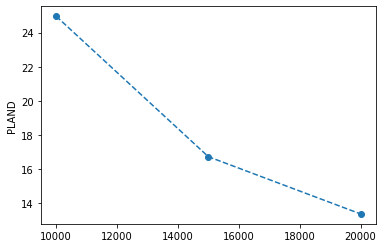

In [7]:
ba.plot_metric('proportion_of_landscape', class_val=URBAN_CLASS_VAL)

Note that the x-axis corresponds to the buffer distances. The specific plot above shows how the proportion of landscape occupied by urban land uses diminishes as the buffer distance around the feature of interest (i.e., the city center of Lausanne).

Likewise `SpatioTemporalAnalysis`, if we want to compute the metrics data frame only for a subset of metrics or classes, or customize how the metrics are computed, we must pass the arguments `metrics`, `classes` or `metrics_kws` to the `compute_class_metrics_df` and `compute_landscape_metrics_df`, as in:

<a id='customizing-buffer-analysis'></a>

In [8]:
metrics=['proportion_of_landscape', 'edge_density', 'fractal_dimension_am']
classes=[1]
metrics_kws={
    'proportion_of_landscape': {'percent': False },
    'edge_density': {'count_boundary': True}
}
ba.compute_class_metrics_df(
    metrics=metrics, classes=[1], metrics_kws=metrics_kws)

metric                 proportion_of_landscape edge_density  \
class_val buffer_dists                                        
1         10000                       0.249648      7.92849   
          15000                       0.167106       6.9376   
          20000                       0.133476      6.29532   

metric                 fractal_dimension_am  
class_val buffer_dists                       
1         10000                     1.15432  
          15000                     1.14603  
          20000                     1.14283

To examine more closely how landscape patterns change as we move along the urban-rural gradient, we might actually want to compute the metrics for each of the buffer rings that lie within each pair of increasing buffer distances. For instance, for the buffer distances considered in this example (i.e., 10000, 15000 and 20000), we would like to compute the metrics for the buffer rings that go from 0 to 10000m, 10000-15000m and 15000-20000m around the center of Lausanne).

To that end, we might pass the argument `buffer_rings=True` when instantiating `BufferAnalysis` as in:

In [9]:
ba = pls.BufferAnalysis(input_filepath,
                        base_mask,
                        buffer_dists,
                        buffer_rings=True,
                        base_mask_crs=base_mask_crs)

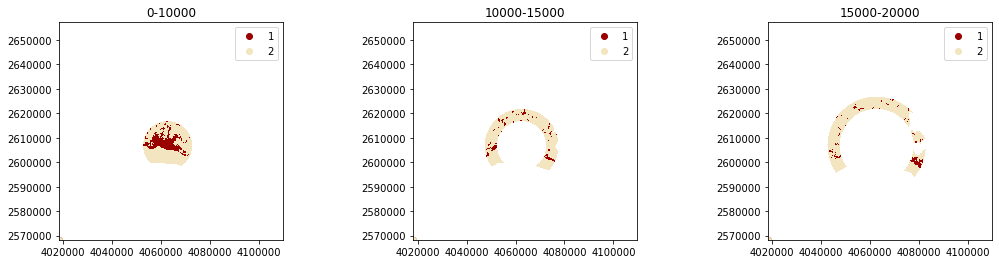

In [10]:
fig = ba.plot_landscapes(cmap=custom_cmap)

In [11]:
ba.compute_class_metrics_df()

metric                 total_area proportion_of_landscape number_of_patches  \
class_val buffer_dists                                                        
1         0-10000            7261                 24.9648                20   
          10000-15000        2369                 8.29976                37   
          15000-20000        2519                 7.54372                37   
2         0-10000           21824                 75.0352                 4   
          10000-15000       26174                 91.7002                 3   
          15000-20000       30873                 92.4563                 8   

metric                 patch_density largest_patch_index total_edge  \
class_val buffer_dists                                                
1         0-10000           0.068764             21.5472     223900   
          10000-15000       0.129629             1.68518     168600   
          15000-20000       0.110805             3.11152     169100   
2         0-10000          0.0137528             74.3614     223900   
          10000-15000      0.0105105             83.6282     168600   
          15000-20000      0.0239578              76.117     169100   

metric                 edge_density landscape_shape_index  area_mn  area_am  \
class_val buffer_dists                                                        
1         0-10000           7.69813               6.74269   363.05  5421.13   
          10000-15000       5.90688               9.14286   64.027  211.007   
          15000-20000       5.06409                8.9901  68.0811  479.645   
2         0-10000           7.69813               4.96622     5456  21434.8   
          10000-15000       5.90688               5.01543  8724.67  21971.1   
          15000-20000       5.06409               5.48864  3859.12  21239.9   

metric                  ... fractal_dimension_md fractal_dimension_ra  \
class_val buffer_dists  ...                                             
1         0-10000       ...              1.08318             0.163172   
          10000-15000   ...              1.06999             0.123043   
          15000-20000   ...              1.07596             0.141466   
2         0-10000       ...              1.06453             0.134831   
          10000-15000   ...              1.04204             0.134779   
          15000-20000   ...              1.06587             0.136933   

metric                 fractal_dimension_sd fractal_dimension_cv  \
class_val buffer_dists                                             
1         0-10000                 0.0434689               4.0267   
          10000-15000              0.028939              2.69333   
          15000-20000             0.0357122              3.33408   
2         0-10000                 0.0538049              4.98227   
          10000-15000             0.0604809              5.61286   
          15000-20000             0.0443751              4.13596   

metric                 euclidean_nearest_neighbor_mn  \
class_val buffer_dists                                 
1         0-10000                            633.891   
          10000-15000                        1016.19   
          15000-20000                        933.734   
2         0-10000                            211.803   
          10000-15000                        223.607   
          15000-20000                        410.485   

metric                 euclidean_nearest_neighbor_am  \
class_val buffer_dists                                 
1         0-10000                            278.966   
          10000-15000                        650.064   
          15000-20000                        631.921   
2         0-10000                            200.209   
          10000-15000                        223.607   
          15000-20000                        1172.21   

metric                 euclidean_nearest_neighbor_md  \
class_val buffer_dists                                 
1         0-10000        

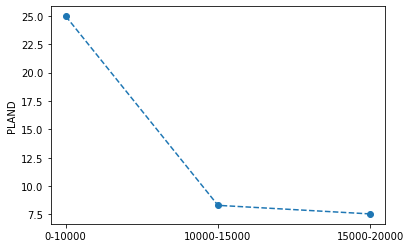

In [12]:
ba.plot_metric('proportion_of_landscape', class_val=URBAN_CLASS_VAL)

### From Polygon

We might as well build our buffer zones from polygon geometries such as administrative boundaries

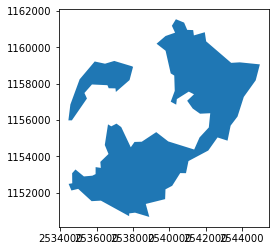

In [13]:
import geopandas as gpd

gdf = gpd.read_file('../data/gmb/g1a18.shp')
base_mask = gdf[gdf['GMDNAME'] == 'Lausanne']['geometry']
base_mask.plot()

Note that in this case, since we are working with a GeoSeries that has a CRS defined, we do not need to set it explicitly with the `base_mask_crs` argument.

In [14]:
base_mask.crs

{'init': 'epsg:2056'}

Also note that since in this case our base mask from which we will define buffer zones is already a polygon. Therefore, we might want to start from smaller buffer distances, even from zero, so that we start computing the metrics for the region defined by the polygon itself (in our example, the administrative boundaries)

In [15]:
buffer_dists = [0, 10000, 20000]

In [16]:
ba = pls.BufferAnalysis(input_filepath, base_mask, buffer_dists)

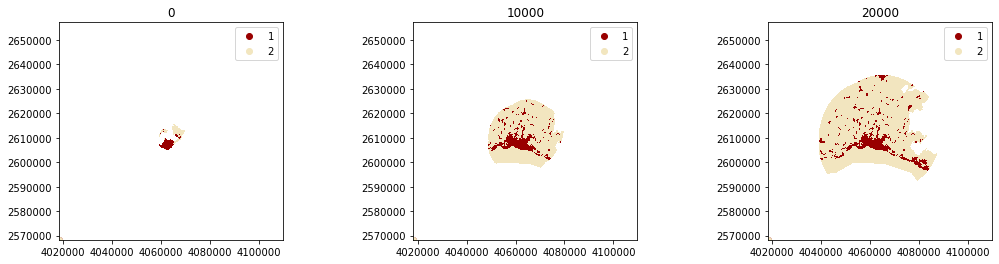

In [17]:
fig = ba.plot_landscapes(cmap=custom_cmap)

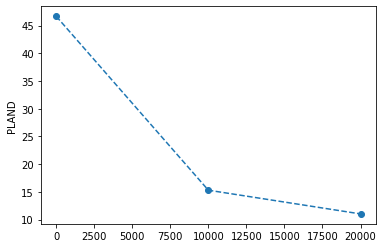

In [18]:
ba.plot_metric('proportion_of_landscape', class_val=URBAN_CLASS_VAL)

## Zonal analysis

We might want to compute the metrics along a decomoposition of the landscape different than concentric buffers, for example, rectangular transects.

We might then use boolean arrays of the same shape of our landscape as masks to define our transects (or any other type of subregion really)

In [19]:
with rasterio.open(input_filepath) as src:
    base_mask_arr = np.full(src.shape,  False)

For instance, let us create three transects of 300x200 cells (30x20km) that horizontally traverse our landscape at the latitude of Lausanne

In [20]:
masks_arr = []
transect_len = 300
for transect_start in range(0, 900, transect_len):
    mask_arr = np.copy(base_mask_arr)
    mask_arr[400:600,transect_start:transect_start+transect_len] = True
    masks_arr.append(mask_arr)

This is how the mask of each transect looks:

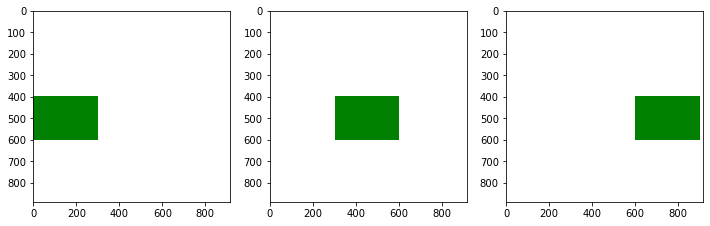

In [21]:
num_subplots = len(masks_arr)
fig = plt.figure(figsize=(num_subplots * 4, 4))
# better colormap to plot mask arrays
mask_cmap = plt.get_cmap('ocean_r')

for i in range(num_subplots):
    ax = fig.add_subplot(1, num_subplots, i + 1)
    ax.imshow(masks_arr[i], cmap=mask_cmap)

We will now use the `ZonalAnalysis` class with the list of mask arrays (corresponding to the transects) that we have constructed above. We can use the keyword argument `attribute_values` to map an identifying value or label to each of our landscapes. 

Here we will use strings that denote that each landscape corresponds to the transect from kilometers 0 to 30, 30 to 60 and 60 to 90 respectively. But we could have used any other list-like argument as long as it is consistent with the number of mask arrays provided through the `masks_arr` argument.

In [22]:
za = pls.ZonalAnalysis(input_filepath,
                       masks_arr=masks_arr,
                       attribute_values=['0-30', '30-60', '60-90'])

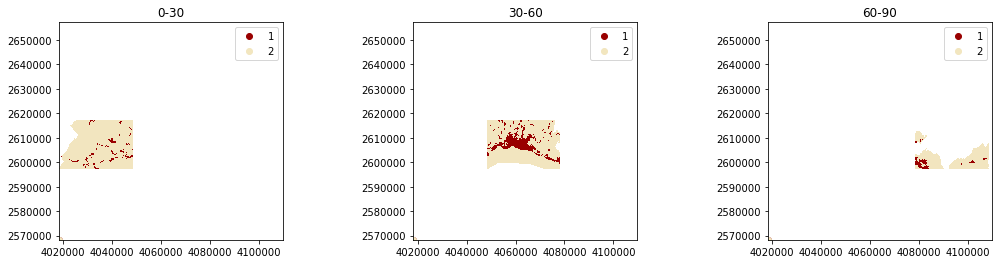

In [23]:
fig = za.plot_landscapes(cmap=custom_cmap)

In [24]:
za.compute_class_metrics_df()

metric                     total_area proportion_of_landscape  \
class_val attribute_values                                      
1         0-30                   2641                  5.0768   
          30-60                  9577                 17.6965   
          60-90                  1761                 9.27281   
2         0-30                  49380                 94.9232   
          30-60                 44541                 82.3035   
          60-90                 17230                 90.7272   

metric                     number_of_patches patch_density  \
class_val attribute_values                                   
1         0-30                            37     0.0711251   
          30-60                           40     0.0739126   
          60-90                            9     0.0473909   
2         0-30                             2     0.0038446   
          30-60                            6     0.0110869   
          60-90                            6     0.0315939   

metric                     largest_patch_index total_edge edge_density  \
class_val attribute_values                                               
1         0-30                        0.707407     216700      4.16563   
          30-60                        12.2806     370500      6.84615   
          60-90                        6.90854      71900        3.786   
2         0-30                         94.9194     216700      4.16563   
          30-60                        81.8859     370500      6.84615   
          60-90                        53.2199      71900        3.786   

metric                     landscape_shape_index  area_mn  area_am  ...  \
class_val attribute_values                                          ...   
1         0-30                           10.7961  71.3784  153.919  ...   
          30-60                          9.63776  239.425  4698.41  ...   
          60-90                          4.71429  195.667  1002.82  ...   
2         0-30                           3.61124    24690    49376  ...   
          30-60                          5.66194   7423.5  44090.7  ...   
          60-90                          3.75665  2871.67  7596.21  ...   

metric                     fractal_dimension_md fractal_dimension_ra  \
class_val attribute_values                                             
1         0-30                          1.08715             0.162565   
          30-60                         1.08185             0.167805   
          60-90                         1.06691             0.129875   
2         0-30                          1.07006             0.116342   
          30-60                         1.05184             0.171006   
          60-90                         1.07797            0.0983169   

metric                     fractal_dimension_sd fractal_dimension_cv  \
class_val attribute_values                                             
1         0-30                        0.0425986              3.92986   
          30-60                       0.0370932              3.42972   
          60-90                       0.0424932               3.9649   
2         0-30                         0.058171              5.43621   
          30-60                       0.0593649              5.59432   
          60-90                       0.0329745              3.08267   

metric                     euclidean_nearest_neighbor_mn  \
class_val attribute_values                                 
1         0-30                                   743.825   
          30-60                                   685.22   
          60-90                                  1585.76   
2         0-30                                   223.607   
          30-60                                  279.945   
          60-90                                  594.107   

metric                     euclidean_nearest_neighbor_am  \
class_val attribute_values                                 
1         0-30                   

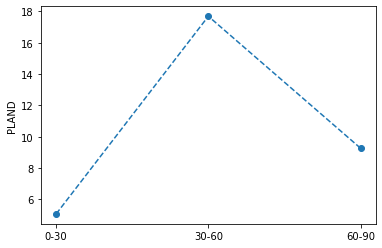

In [25]:
za.plot_metric('proportion_of_landscape', class_val=URBAN_CLASS_VAL)

Note that the values that we pass to `attribute_values` will be used within the metric dataframes and plot labels.

Finally, note that the data frames for `ZonalAnalysis`, likewise those of `SpatioTemporalAnalysis` or `BufferAnalysis` (see [above](#customizing-buffer-analysis)) can be customized via by passing the arguments `metrics`, `classes` or `metrics_kws` to the `compute_class_metrics_df` and `compute_landscape_metrics_df` methods.

## See also

* [SpatioTemporalBufferAnalysis](https://github.com/martibosch/pylandstats-notebooks/blob/master/notebooks/04-spatiotemporal-buffer-analysis.ipynb)